BSTS model for forecasting is chose for uncertainty quantification. it also provides causal impact analysis.

In [42]:
# Make sure your data_cleaning.py is in the same folder or in your PYTHONPATH
from dataCleaning import load_data, clean_data

df = load_data("climate_change_impact_on_agriculture_2024.csv")
df_clean = clean_data(df)

In [ ]:
import pandas as pd
from orbit.models import DLT
from orbit.diagnostics.plot import plot_predicted_data
from orbit.diagnostics.metrics import smape
from orbit.utils.dataset import load_iclaims
import matplotlib.pyplot as plt

# Aggregate by year
df_agg = df_clean.groupby('Year').agg({
    'Crop_Yield_MT_per_HA': 'mean',
    'Average_Temperature_C': 'mean',
    'Total_Precipitation_mm': 'mean',
    'Irrigation_Access_percent': 'mean',
    'Fertilizer_Use_KG_per_HA': 'mean',
    'Soil_Health_Index': 'mean'
}).reset_index()


# Prepare data for BSTS model
# Orbit requires a datetime column; let's simulate this using the year
df_agg['date'] = pd.to_datetime(df_agg['Year'], format='%Y')
df_agg = df_agg.rename(columns={
    'Crop_Yield_MT_per_HA': 'y',
    'Average_Temperature_C': 'temp',
    'Total_Precipitation_mm': 'precip',
    'Irrigation_Access_percent': 'irrigation',
    'Fertilizer_Use_KG_per_HA': 'fertilizer',
    'Soil_Health_Index': 'soil_health'
})

# BSTS with DLT (Dynamic Linear Trend) model
model = DLT(
    response_col='y',
    date_col='date',
    regressor_col=['temp', 'precip', 'irrigation', 'fertilizer', 'soil_health'],
    seasonality=1,
)
# Fit the model
model.fit(df_agg)

2025-06-12 14:07:42 - orbit - INFO - Sampling (CmdStanPy) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (CmdStanPy) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 00:01 Sampling completed                   
chain 2 |██████████| 00:01 Sampling completed

chain 3 |██████████| 00:01 Sampling completed
chain 4 |██████████| 00:01 Sampling completed                   

In [50]:
# Print the model summary
coef_df = model.get_regression_coefs()
print(coef_df.head())


     regressor regressor_sign  coefficient  coefficient_lower  \
0         temp        Regular     0.021583          -0.012744   
1       precip        Regular     0.000519           0.000059   
2   irrigation        Regular     0.008685          -0.002015   
3   fertilizer        Regular    -0.001237          -0.011120   
4  soil_health        Regular    -0.006384          -0.017851   

   coefficient_upper  Pr(coef >= 0)  Pr(coef < 0)  
0           0.057373           0.80          0.20  
1           0.000978           0.97          0.03  
2           0.018885           0.90          0.10  
3           0.010181           0.36          0.64  
4           0.009897           0.24          0.76  


In [56]:
# Forecasting years
forecast_years = [2030, 2040, 2050]

# Create forecast DataFrame
future_df = pd.DataFrame({
    'date': pd.to_datetime(forecast_years, format='%Y'),
    'temp': [df_agg['temp'].mean()] * 3,
    'precip': [df_agg['precip'].mean()] * 3,
    'irrigation': [df_agg['irrigation'].mean()] * 3,
    'fertilizer': [df_agg['fertilizer'].mean()] * 3,
    'soil_health': [df_agg['soil_health'].mean()] * 3,
})

# Predict
forecast = model.predict(future_df)

# Display results
forecast['year'] = forecast['date'].dt.year
print(forecast[['year', 'prediction_5', 'prediction', 'prediction_95']])


   year  prediction_5  prediction  prediction_95
0  2030      2.044306    2.180501       2.328040
1  2040      2.019287    2.188895       2.341474
2  2050      1.942896    2.164589       2.302080


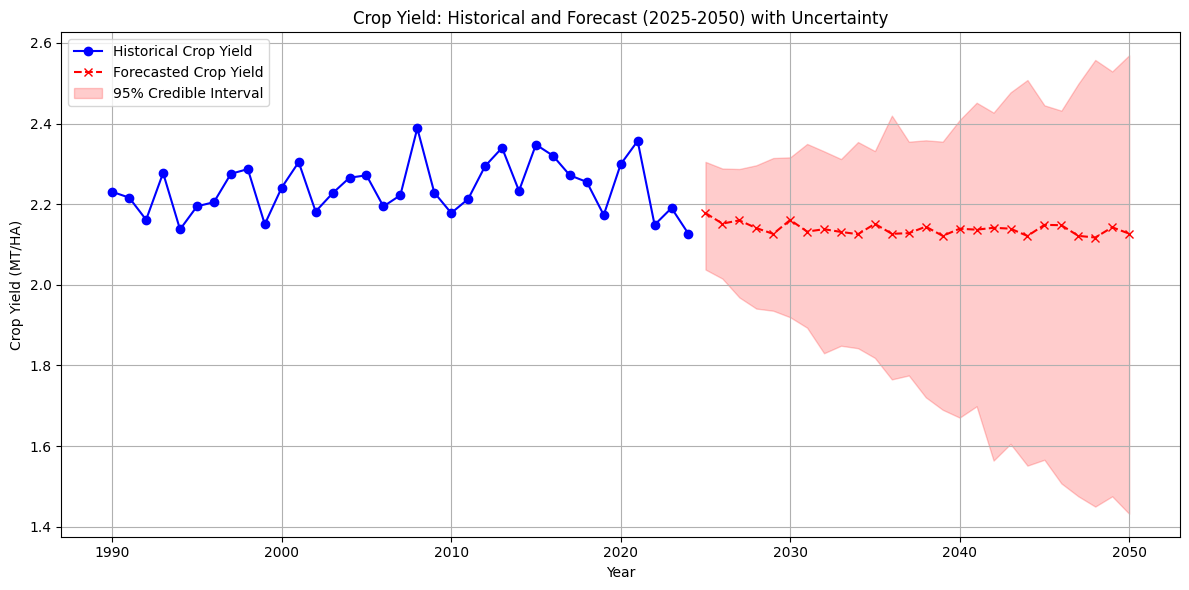

In [57]:
# Historical data (actual observed yields)
historical = df_agg[['date', 'y']].copy()

# Forecast data with uncertainty bounds
forecast = forecast_df[['date', 'prediction', 'prediction_5', 'prediction_95']].copy()

plt.figure(figsize=(12, 6))

# Plot historical crop yield
plt.plot(historical['date'], historical['y'], label='Historical Crop Yield', marker='o', color='blue')

# Plot forecasted crop yield (mean prediction)
plt.plot(forecast['date'], forecast['prediction'], label='Forecasted Crop Yield', marker='x', linestyle='--', color='red')

# Plot uncertainty as shaded area
plt.fill_between(forecast['date'], 
                 forecast['prediction_5'], 
                 forecast['prediction_95'], 
                 color='red', alpha=0.2, label='95% Credible Interval')

plt.title('Crop Yield: Historical and Forecast (2025-2050) with Uncertainty')
plt.xlabel('Year')
plt.ylabel('Crop Yield (MT/HA)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
